In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from utils import boxcox_transform
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook
OUT_DIR = Path('./output')

In [2]:
seller_feat = pd.read_csv(OUT_DIR/'seller_feat.csv')

In [3]:
seller_feat.head()

,seller_id,days_from_ref_date,total_order,age,freq,days_btw_order,monetary_avg,monetary_sum,quantity_avg,ncats
0,0015a82c2db000af6aaaf3ae2ecb0532,321,3,343,0.008746,114.333333,895.000000,2685.00,1.000000,1
1,001cca7ae9ae17fb1caed9dfb1094831,54,200,577,0.346620,2.885000,125.400150,25080.03,1.195000,2
2,002100f778ceb8431b7a1020ff7ab48f,145,51,355,0.143662,6.960784,24.205882,1234.50,1.078431,1
3,003554e2dce176b5555353e4f3555ac8,263,1,263,0.003802,263.000000,120.000000,120.00,1.000000,1
4,004c9cd9d87a3c30c522c48c4fc07416,124,158,585,0.270085,3.702532,124.763987,19712.71,1.075949,2


In [4]:
feat = seller_feat.iloc[:,1:]

In [5]:
# transform
feat ,_ = boxcox_transform(feat)

In [6]:
# scaling
scaler = StandardScaler()
feat = scaler.fit_transform(feat)

## Clustering

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


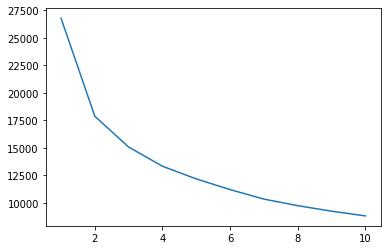

In [7]:
wcss=[]
for i in tqdm_notebook(range(1,11)):
    k_model = KMeans(n_clusters=i,n_jobs=-1,random_state=42)
    _ = k_model.fit(feat)
    wcss.append(k_model.inertia_)
_ = plt.plot(range(1,11),wcss)

In [10]:
k_model = KMeans(n_clusters=4, n_jobs=-1, random_state=0)
label = k_model.fit_predict(feat)
seller_feat['segment_id'] = label

In [11]:
seller_feat['segment_id'].value_counts()

0    809
2    790
3    695
1    683
Name: segment_id, dtype: int64

## Segment profiling

In [12]:
feats = ['days_from_ref_date', 'total_order', 'age', 'freq', 'days_btw_order',
         'monetary_avg', 'monetary_sum', 'quantity_avg', 'ncats']

segment_profile = seller_feat.groupby('segment_id').mean()[feats]

# merge with segment seller counts
segment_profile = segment_profile.merge(seller_feat.groupby('segment_id')['seller_id']\
                                        .count().reset_index(), on='segment_id')

segment_profile = segment_profile.rename({'days_from_ref_date':'recency','seller_id':'nsellers'},axis=1)

In [13]:
segment_profile.head()

,segment_id,recency,total_order,age,freq,days_btw_order,monetary_avg,monetary_sum,quantity_avg,ncats,nsellers
0,0,31.249691,5.826947,111.228677,0.061489,24.377430,177.166985,824.121187,1.144060,1.438813,809
1,1,205.733529,11.345534,441.904832,0.025903,65.332024,326.437273,2482.057701,1.289047,2.042460,683
2,2,35.515190,107.712658,385.474684,0.281165,7.433594,154.610449,13747.306114,1.128211,3.908861,790
3,3,303.774101,1.972662,347.981295,0.006928,239.765337,135.492365,215.675209,1.069512,1.109353,695


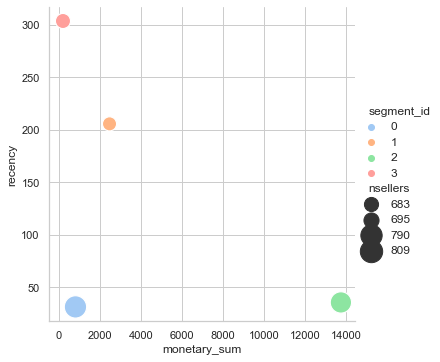

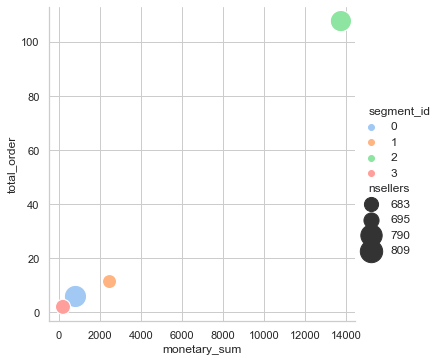

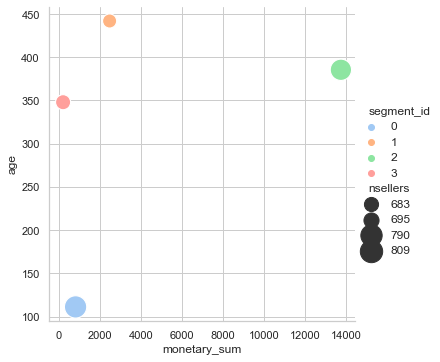

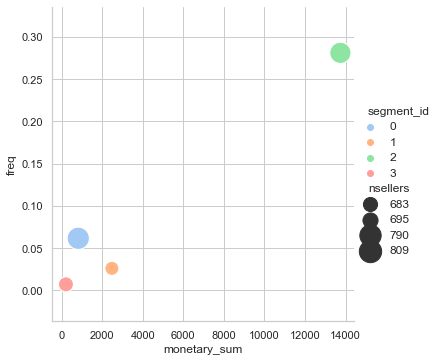

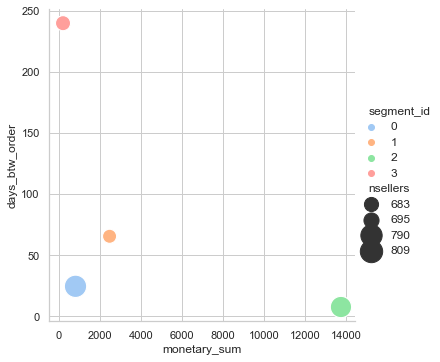

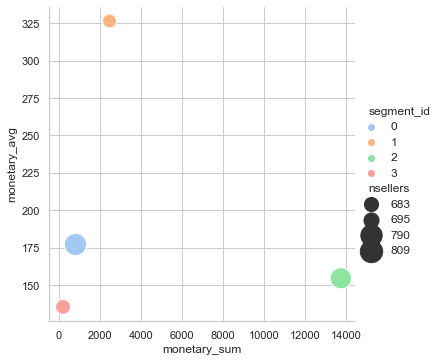

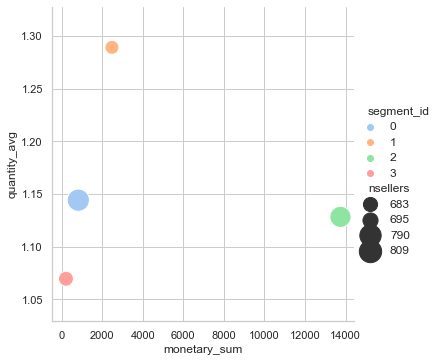

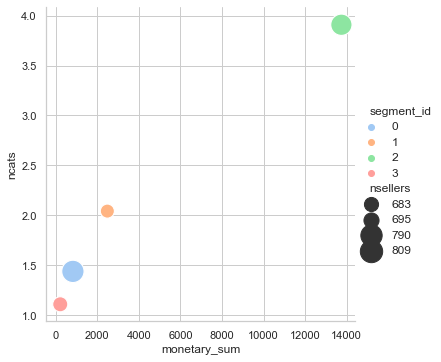

In [24]:
sns.set_theme(style="whitegrid")
feats = ['recency', 'total_order', 'age', 'freq', 'days_btw_order',
         'monetary_avg', 'monetary_sum', 'quantity_avg', 'ncats']

main_feat = 'monetary_sum'
for feat in feats:
    if feat != main_feat:
        _ = sns.relplot(x=main_feat, y=feat, hue='segment_id', size='nsellers',
                    sizes=(200,500), data=segment_profile, palette='pastel')

Segment profile:
- 0 : Rising star 
- 1 : X potential customer - (large basket / small volume)
- 2 : Highest value sellers (small basket/ large volume)
- 3 : Inactive